In [1]:
# The dataset is from https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
# The original code is from https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


# Data loading & Dataset information

In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#data processing
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


2022-12-04 21:24:00.094976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 21:24:00.096052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 21:24:00.096762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 21:24:00.098794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<Figure size 432x288 with 0 Axes>

In [3]:
df_train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

## Dataset before preprocessing's snapshot

In [4]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Keeps the original tweet and sentiment only, drop unrelated columns

In [5]:
df_train = df_train[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

## Dataset after dropped unrelated content

In [6]:
df_train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Cleaning the data

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [8]:
# code from https://www.kaggle.com/code/tharunikag/corona-virus-tweets-classification
# Cleaning the text

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def preprocessor(data):
    corpus = []
    for i in range(len(data)):
        #remove urls
        tweet1= re.sub(r'http\S+', ' ', data['OriginalTweet'][i])
        #remove html tags
        tweet2 = re.sub(r'<.*?>',' ', tweet1) 
        #remove digits
        tweet3 = re.sub(r'\d+',' ', tweet2)
        #remove hashtags
        tweet4 = re.sub(r'#\w+',' ', tweet3)
        review = re.sub('[^a-zA-Z]', ' ', tweet4)
        review = review.lower()
        review = review.split()
        # ps = PorterStemmer()
        # review = [ps.stem(word) for word in review if word not in all_stopwords]
        lemmatizer = WordNetLemmatizer()
        review = [lemmatizer.lemmatize(word) for word in review if word not in all_stopwords]
        review = ' '.join(review)
        corpus.append(review)
    return corpus   

In [9]:
df_train["text_clean"] = preprocessor(df_train)
df_test["text_clean"] = preprocessor(df_test)

After cleaning the text content:

In [10]:
df_train.head()

,OriginalTweet,Sentiment,text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,menyrbie phil gahan chrisitv
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,Positive,food stock not one empty please panic enough f...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready go supermarket outbreak not paranoid foo...


## Wordcloud of cleaned data

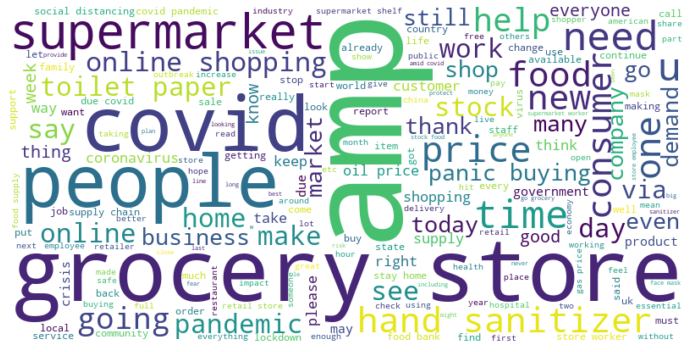

In [11]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.text_clean))
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Different label distribution in the dataset

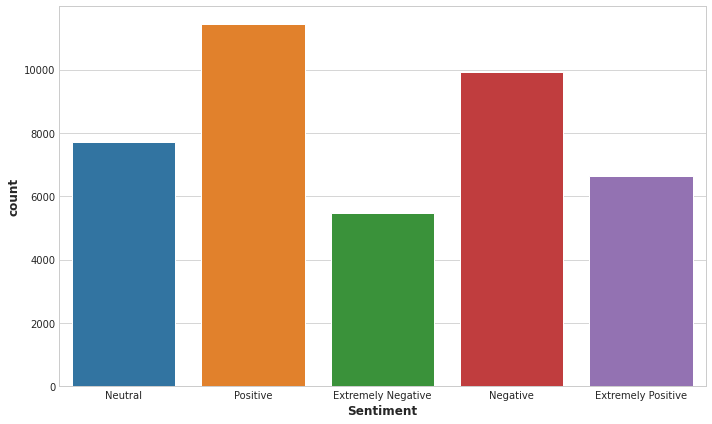

In [12]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure(figsize=(10,6))
sns.countplot(x = df_train["Sentiment"], data = df_train)
plt.show()

In [13]:
df_train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [14]:
# can set only 3 label here
df_train['Sentiment'] = df_train['Sentiment'].map({'Extremely Negative':0,'Negative':1,'Neutral':2,'Positive':3,'Extremely Positive':4})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':1,'Neutral':2,'Positive':3,'Extremely Positive':4})

## Class balancing

In [15]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

### After oversampling, each label looks like:

In [16]:
train_os['Sentiment'].value_counts()

2    11422
3    11422
0    11422
1    11422
4    11422
Name: Sentiment, dtype: int64

### Train - test - validation splitting (85: 10 : 5)

In [17]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 51399
VALIDATION DATA: 5711
TESTING DATA: 3798


## One hot encoding

one hot encoding on the target variable can help us to get higher accuracy rather than label encoding

In [18]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 51399
VALIDATION DATA: 5711
TESTING DATA: 3798


# BERT Model implementation

## tokenize train-test-value tweet content

In [19]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_feature = 128

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
def tokenize(data,max_feature) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_feature,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [21]:
train_input_ids, train_attention_masks = tokenize(X_train, max_feature)
val_input_ids, val_attention_masks = tokenize(X_valid, max_feature)
test_input_ids, test_attention_masks = tokenize(X_test, max_feature)

## import Bert model

In [59]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [60]:
def create_model(bert_model, max_len=max_feature):
    # parameters
    # optimizer adam, lr annealing
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    opt = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # use categorical cross entropy to train model
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    # drop out layer can help reduce overfitting 
    # drop_out_layer = tf.keras.layers.Dropout(0.2)

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')  
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    embeddings = bert_model([input_ids,attention_masks])[1]
    drop_out_embeddings = tf.keras.layers.Dropout(0.1)(embeddings)
    output = tf.keras.layers.Dense(5, activation="softmax")(drop_out_embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    return model

## Model description

In [61]:
model = create_model(bert_model, max_feature)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
dropout_85 (Dropout)            (None, 768)          0           tf_bert_model_1[0][1]      

## Training

In [62]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=5, batch_size=32)

Epoch 1/5
1607/1607 [==============================] - 818s 492ms/step - loss: 0.7355 - categorical_accuracy: 0.7098 - val_loss: 0.4628 - val_categorical_accuracy: 0.8316
Epoch 2/5
1607/1607 [==============================] - 786s 489ms/step - loss: 0.4218 - categorical_accuracy: 0.8493 - val_loss: 0.4052 - val_categorical_accuracy: 0.8552
Epoch 3/5
1607/1607 [==============================] - 787s 490ms/step - loss: 0.2957 - categorical_accuracy: 0.8963 - val_loss: 0.3611 - val_categorical_accuracy: 0.8773
Epoch 4/5
1607/1607 [==============================] - 786s 489ms/step - loss: 0.2089 - categorical_accuracy: 0.9285 - val_loss: 0.4330 - val_categorical_accuracy: 0.8690
Epoch 5/5
1607/1607 [==============================] - 786s 489ms/step - loss: 0.1515 - categorical_accuracy: 0.9500 - val_loss: 0.3891 - val_categorical_accuracy: 0.8918


# Evaluation

In [63]:
result_bert = model.predict([test_input_ids,test_attention_masks])
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

### Test Accuracy and Loss

In [76]:
acc = accuracy_score(y_test, y_pred_bert)
print('Test Accuracy: %.2lf' % (acc*100))

Test Accuracy: 77.62


### Plot the Loss & Accuracy

In [79]:
def history_plot(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['categorical_accuracy'], label='train accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

### Loss and Accuracy
as we can see here, the model is overfitting when epoch is between 1 and 2, so maybe next time we can consider to reduce number of epoch, thus we can increase the training speed and get better generalization

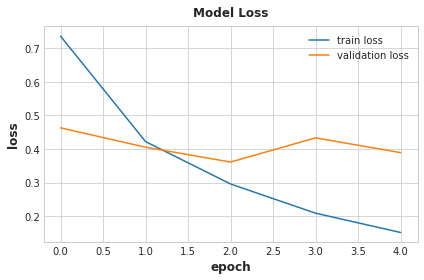

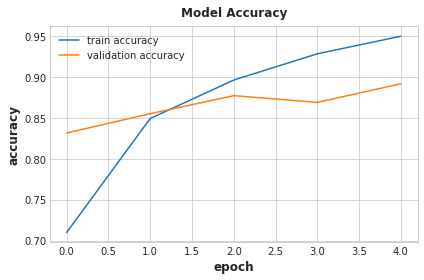

In [80]:
history_plot(history_bert)

### Classification Report

In [81]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Extremely Negative','Negative', 'Neutral', 'Positive','Extremely Positive']))

	Classification Report for BERT:

                     precision    recall  f1-score   support

Extremely Negative       0.81      0.78      0.79       592
          Negative       0.75      0.73      0.74      1041
           Neutral       0.83      0.81      0.82       619
          Positive       0.73      0.77      0.75       947
Extremely Positive       0.81      0.82      0.82       599

         micro avg       0.78      0.78      0.78      3798
         macro avg       0.79      0.78      0.78      3798
      weighted avg       0.78      0.78      0.78      3798
       samples avg       0.78      0.78      0.78      3798



### Confusion Matrix

From the confusion matrix we can know that the model is not very good at distinguish the extremely negative,
even though we have already used oversampling, maybe we should try add some datapoints to the extremely negative class to see if we can give model more training sample, to help it learn better.

[Text(0.5, 1.0, 'Bert Confusion Matrix ')]

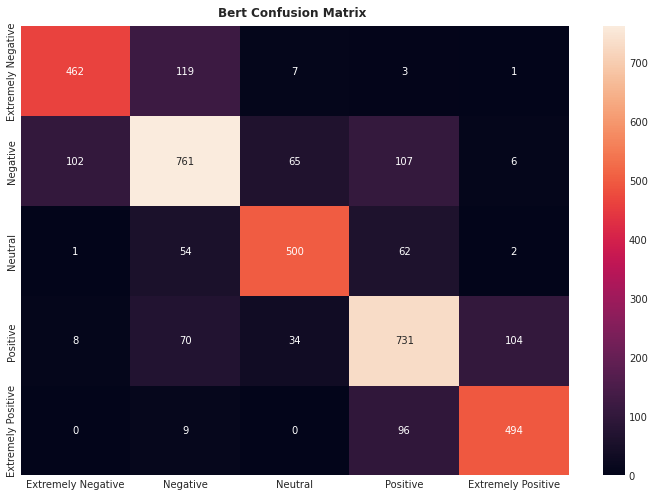

In [104]:
cf_matrix = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))
cf_matrix = pd.DataFrame(cf_matrix, index = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'],
                  columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, fmt='g', cbar=True).set(title='Bert Confusion Matrix ')